# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip3 install lightgbm

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import time
from lightgbm import LGBMRegressor
import lightgbm

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv(r'C:\Users\ASUS\Desktop\Практикум\Data\autos.csv')

Изучите данные.

In [4]:
data.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Описанние данных:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро)

In [6]:
data = data.rename(columns=str.lower)

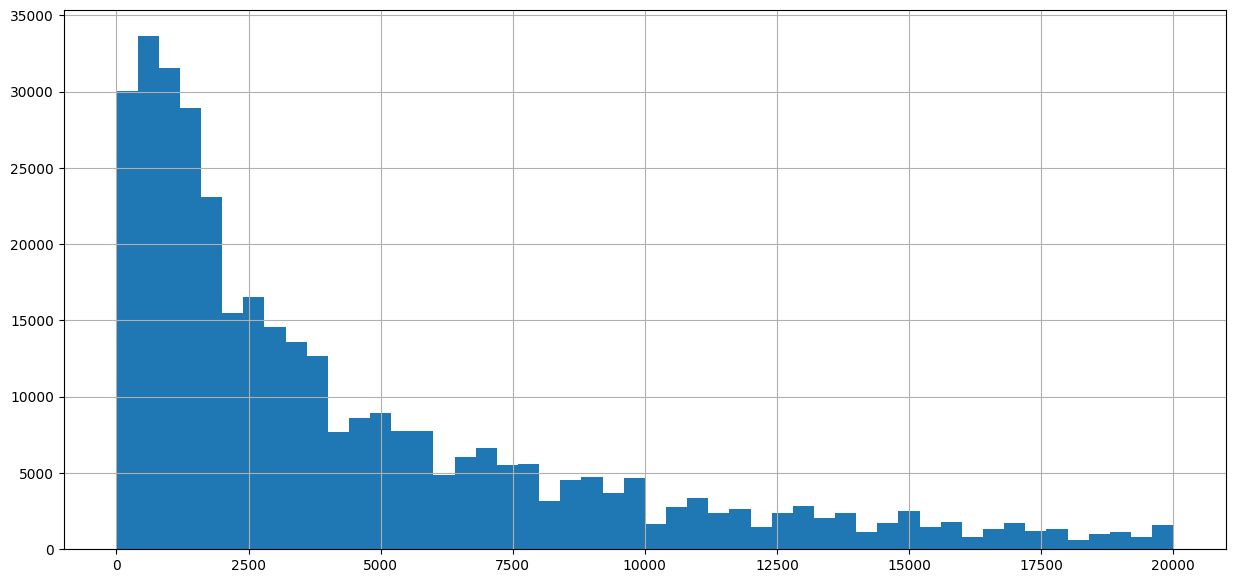

In [7]:
data['price'].hist(bins = 50,figsize=(15,7));

Так как цена это целевой признак удалим все строки с ценой ниже 150 евро, эти объявления могуть быть на металалом или ссылки на внешний сайт. 


In [8]:
data.drop(data[data['price'] <= 150].index, inplace=True)

In [9]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'sonstige_autos', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'trabant', 'land_rover', 'lada'], dtype=object)

In [10]:
data[data['brand'] == 'sonstige_autos']

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20 00:00:00,0,90562,2016-04-03 04:17:08
650,2016-03-30 11:55:46,15000,coupe,1971,NaN,0,NaN,5000,4,NaN,sonstige_autos,no,2016-03-30 00:00:00,0,51145,2016-04-07 02:45:10
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no,2016-04-01 00:00:00,0,17309,2016-04-07 14:56:03
700,2016-03-30 21:37:21,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no,2016-03-30 00:00:00,0,81929,2016-04-05 11:18:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353961,2016-03-17 13:54:22,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN,2016-03-17 00:00:00,0,42289,2016-03-31 22:46:47
354062,2016-03-19 11:25:16,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no,2016-03-19 00:00:00,0,63069,2016-04-07 00:46:42
354073,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN,2016-03-19 00:00:00,0,6188,2016-04-01 01:47:17
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15 00:00:00,0,91186,2016-03-17 08:16:25


Удалим строчки с sonstige_autos, скорее всего это стороний сервис по продаже авто 

In [11]:
data.drop(data[data['brand'] == 'sonstige_autos'].index, inplace=True)

Удалим автомобили старше 80х годов, так как эти автомобили уже можно считать винтажными и цена может зависить от совершенно других факторов 

In [12]:
data.drop(data[data['registrationyear'] <= 1979].index, inplace=True)

Удалим также автомобили старше 2017 года, так как база данных собрана в 2016

In [13]:
data.drop(data[data['registrationyear'] > 2017].index, inplace=True)

Удалим строки где мощность выше 1000 и строеи где мощность выше 500 при цене ниже 10000 евро, это выгядит правдоподавно в нашем ценовом диапазоне 

In [14]:
data.drop(data[data['power'] > 1000].index, inplace=True)

In [15]:
data.drop(data[(data['price'] < 10000) & (data['power'] > 500)].index, inplace=True)


Заполните пропущенные значения и обработайте аномалии в столбцах.

In [16]:
data.isna().sum()

datecrawled              0
price                    0
vehicletype          27099
registrationyear         0
gearbox              14265
power                    0
model                13307
kilometer                0
registrationmonth        0
fueltype             24875
brand                    0
repaired             59744
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [17]:
data[data['model'].isna()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-07 00:00:00,0,26789,2016-04-03 11:46:59
354234,2016-03-19 01:47:31,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18 00:00:00,0,85221,2016-04-06 03:45:36
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07 00:00:00,0,55743,2016-03-12 21:45:25
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


In [18]:
data.isna().sum()

datecrawled              0
price                    0
vehicletype          27099
registrationyear         0
gearbox              14265
power                    0
model                13307
kilometer                0
registrationmonth        0
fueltype             24875
brand                    0
repaired             59744
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [19]:
data["vehicletype"] = data["vehicletype"].fillna(data["vehicletype"].mode().values[0])
data["gearbox"] = data["gearbox"].fillna(data["gearbox"].mode().values[0])
data["fueltype"] = data["fueltype"].fillna(data["fueltype"].mode().values[0])
data = data.drop(data.loc[data['model'].isna()].index, axis=0)
data["repaired"] = data["repaired"].fillna("no")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315240 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        315240 non-null  object
 1   price              315240 non-null  int64 
 2   vehicletype        315240 non-null  object
 3   registrationyear   315240 non-null  int64 
 4   gearbox            315240 non-null  object
 5   power              315240 non-null  int64 
 6   model              315240 non-null  object
 7   kilometer          315240 non-null  int64 
 8   registrationmonth  315240 non-null  int64 
 9   fueltype           315240 non-null  object
 10  brand              315240 non-null  object
 11  repaired           315240 non-null  object
 12  datecreated        315240 non-null  object
 13  numberofpictures   315240 non-null  int64 
 14  postalcode         315240 non-null  int64 
 15  lastseen           315240 non-null  object
dtypes: int64(7), object(

In [20]:
data = data.drop(['datecrawled', 'registrationmonth', 'datecreated', 'postalcode', 'lastseen','numberofpictures'], axis='columns')

In [21]:
data.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

In [22]:
data.registrationyear.max()

2017

## Обучение моделей

Подготовьте выборки для обучения моделей.

In [23]:
# Определение признаков и целевого признака
features = data.drop(['price'], axis=1)
target = data['price']

In [24]:
# Разделение данных на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [25]:
# Кодирование категориальных признаков
encoder = OrdinalEncoder(handle_unknown='ignore')
encoder.fit(features_train)
features_train = pd.DataFrame(encoder.transform(features_train))
features_test = pd.DataFrame(encoder.transform(features_test))

In [26]:
# Создание набора данных для LightGBM
train_data = lightgbm.Dataset(
    features_train, label=target_train, free_raw_data=False)

In [27]:
# Параметры для поиска по сетке для LightGBM
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [15, 20]}

In [28]:
# Создание модели LightGBM
lgbm = lightgbm.LGBMRegressor(n_jobs=4)

# Поиск по сетке для LightGBM
grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=0,
    scoring='neg_mean_squared_error',
)
grid.fit(features_train, target_train)
print('Лучшие параметры:', grid.best_params_)
print('Лучшее значение метрики:', grid.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 252192, number of used features: 9
[LightGBM] [Info] Start training from score 4682.893966
Лучшие параметры: {'learning_rate': 0.3, 'max_depth': 15}
Лучшее значение метрики: -2590867.6937615247


In [29]:
start_time = time.time()

grid.fit(features_train, target_train)

end_time = time.time()
fit_lgbm = end_time - start_time
print('Время обучения модели:', fit_lgbm , 'секунд')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 252192, number of used features: 9
[LightGBM] [Info] Start training from score 4682.893966
Время обучения модели: 7.05900764465332 секунд


In [30]:

grid.best_estimator_.fit(features_train, target_train)
fit_lgbm = grid.refit_time_
print('Время обучения модели:', fit_lgbm , 'секунд')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 252192, number of used features: 9
[LightGBM] [Info] Start training from score 4682.893966
Время обучения модели: 0.38295674324035645 секунд


In [31]:
# Вывод лучших параметров и RMSE для LightGBM

print(grid.best_params_)
print('RMSE для LightGBM модели на валидационной выборке: {:.2f}'.format(
    (-grid.best_score_)**0.5))

{'learning_rate': 0.3, 'max_depth': 15}
RMSE для LightGBM модели на валидационной выборке: 1609.62


In [32]:
# Предсказание и вычисление RMSE для LightGBM на обучающей выборке
start = time.time()
prediction = grid.predict(features_train)
prdict_lgbm = time.time() - start
mse = mean_squared_error(target_train, prediction)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("Fit:", fit_lgbm)
print("Predict:", prdict_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
MSE: 2385052.98
RMSE: 1544.36
Fit: 0.38295674324035645
Predict: 0.22603344917297363


In [33]:
# Параметры для поиска по сетке для случайного леса
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20],
    'max_features': [3],
    'n_estimators': [80, 100, 120]
}

In [34]:
# Создание модели случайного леса
rf = RandomForestRegressor()

# Поиск по сетке для случайного леса
start = time.time()
grid_search_final = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=2,
    n_jobs=-1,
    verbose=2).fit(features_train, target_train)
fit_rfr = grid_search_final.refit_time_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


In [35]:
# Вывод лучших параметров и RMSE для случайного леса
best_parameters_final = grid_search_final.best_params_
best_estimator_final = grid_search_final.best_estimator_
rfc_final = cross_val_score(
    best_estimator_final,
    features_train,
    target_train,
    scoring='neg_mean_squared_error',
    cv=4).mean()
print(best_parameters_final)
print(abs(rfc_final)**(0.5))

{'bootstrap': True, 'max_depth': 20, 'max_features': 3, 'n_estimators': 120}
1539.1534832861232


In [36]:
# Предсказание и вычисление времени предсказания для случайного леса на обучающей выборке
start = time.time()
bf = best_estimator_final.predict(features_train)
predict_rfr = time.time() - start

In [37]:
# Вывод результатов для случайного леса
print('RandomForest')
print("RMSE:",abs(rfc_final)**(0.5))
print("Время Обучения:", fit_rfr)
print("Скорость работы:", predict_rfr)

RandomForest
RMSE: 1539.1534832861232
Время Обучения: 21.819607257843018
Скорость работы: 6.993720293045044


In [38]:
# Вывод результатов для LightGBM
print('LGBM')
print("RMSE: %.2f" % rmse)
print("Время Обучения:", fit_lgbm)
print("Скорость работы", prdict_lgbm)

LGBM
RMSE: 1544.36
Время Обучения: 0.38295674324035645
Скорость работы 0.22603344917297363


Лучшие результаты показала модель Случаного леса с резутатом RMSE 1539.011 при скорости работы 7.317392349243164, однако RMSE у LightGBM лишь немного хуже, а время выполнения заметно лучше, поэтому используем эту модель 

In [39]:
%%time
# Предсказание на тестовых данных
target_pred = grid.predict(features_test)

# Вычисление RMSE
rmse = mean_squared_error(target_test, target_pred, squared=False)
print('RMSE на тестовых данных:', rmse)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE на тестовых данных: 1592.3505236556293
CPU times: total: 188 ms
Wall time: 60.5 ms


Вывод

После исследованния моделей для заказчика рекоммендуется использовать модель LightGBM, так как она показывает хорошее качество и работает достаточно бсытро. 